# Observed Kappa
Find the observed kappa based on the activation diameters observed.

In [1]:
from closure_funcs import *
import numpy as np
from scipy.optimize import root_scalar
from matplotlib import pyplot as plt
import pandas as pd
from tqdm import tqdm
from joblib import Parallel, delayed
from scipy.stats import linregress
import matplotlib.colors as mcolors

Read data

In [2]:
d = pd.read_csv('../tables/2024_03_11_merged.csv', parse_dates=['Time_Mid'])
d['ams_tot'] = d.loc[:,['Org_Ave_IsoK_STP', 'SO4_Ave_IsoK_STP', 'NO3_Ave_IsoK_STP', 'NH4_Ave_IsoK_STP', 'Chl_Ave_IsoK_STP']].sum(axis=1)
merged = d
merged = merged[np.logical_not(((merged['Ice_Flag_2DS']==1) & (merged['Time_Mid'].dt.month.isin([11, 12, 1, 2, 3, 4]))) | (merged['ED-liquid_2DS']>=60E-6) | (merged['LWC_FCDP']>=0.005))]# I removed the AMS filter #  | (merged['ams_tot'] <= 0.04)
d = merged.reset_index(drop=True)

Find activation diameter

Stored as `'D_a'`

In [3]:
d['D_a'] = np.nan
for i in range(0,len(d)):
    d.loc[i,'D_a']

In [4]:
# upper and lower bounds of SMPS + LAS
lower_bounds = [2.97, 3.36, 3.76, 4.22, 4.74, 5.32, 5.97, 6.69, 7.51, 8.43, 9.46, 10.6, 11.9, 13.4, 15.0, 16.8, 18.9, 21.2, 23.8, 26.7, 29.9, 33.6, 37.6, 42.2, 47.4, 53.2, 59.7, 66.9, 75.1, 84.3, 93.9, 106.1, 119.0, 133.6, 149.9, 168.2, 188.7, 211.7, 237.5, 266.5, 299.0, 335.5, 376.5, 422.4, 473.9, 531.8, 596.6, 669.5, 751.1, 842.8, 945.6, 1129.5, 1421.9, 1790.1, 2253.6, 2837.1]
upper_bounds = [3.36, 3.76, 4.22, 4.74, 5.32, 5.97, 6.69, 7.51, 8.43, 9.46, 10.6, 11.9, 13.4, 15.0, 16.8, 18.9, 21.2, 23.8, 26.7, 29.9, 33.6, 37.6, 42.2, 47.4, 53.2, 59.7, 66.9, 75.1, 84.3, 94.0, 106.1, 119.0, 133.6, 149.9, 168.2, 188.7, 211.7, 237.5, 266.5, 299.0, 335.5, 376.5, 422.4, 473.9, 531.8, 596.6, 669.5, 751.1, 842.8, 945.6, 1129.5, 1421.9, 1790.1, 2253.6, 2837.1, 3487.5]

# calculates dlogd using upper and lower bounds
dlogd=[]
for i in range(0,len(lower_bounds)):
       dlogd.append(np.log10(upper_bounds[i]) - np.log10(lower_bounds[i]))

In [5]:
# list of all the bin column labels for SMPS and LAS
b_l = ['SMPS_Bin01', 'SMPS_Bin02', 'SMPS_Bin03', 'SMPS_Bin04', 'SMPS_Bin05',
       'SMPS_Bin06', 'SMPS_Bin07', 'SMPS_Bin08', 'SMPS_Bin09', 'SMPS_Bin10',
       'SMPS_Bin11', 'SMPS_Bin12', 'SMPS_Bin13', 'SMPS_Bin14', 'SMPS_Bin15',
       'SMPS_Bin16', 'SMPS_Bin17', 'SMPS_Bin18', 'SMPS_Bin19', 'SMPS_Bin20',
       'SMPS_Bin21', 'SMPS_Bin22', 'SMPS_Bin23', 'SMPS_Bin24', 'SMPS_Bin25',
       'SMPS_Bin26', 'SMPS_Bin27', 'SMPS_Bin28', 'SMPS_Bin29', 'SMPS_Bin30',
       'LAS_Bin01', 'LAS_Bin02', 'LAS_Bin03', 'LAS_Bin04', 'LAS_Bin05',
       'LAS_Bin06', 'LAS_Bin07', 'LAS_Bin08', 'LAS_Bin09', 'LAS_Bin10',
       'LAS_Bin11', 'LAS_Bin12', 'LAS_Bin13', 'LAS_Bin14', 'LAS_Bin15',
       'LAS_Bin16', 'LAS_Bin17', 'LAS_Bin18', 'LAS_Bin19', 'LAS_Bin20',
       'LAS_Bin21', 'LAS_Bin22', 'LAS_Bin23', 'LAS_Bin24', 'LAS_Bin25',
       'LAS_Bin26']

In [6]:
# integrates LAS + SMPS from largest to smallest bin until it is equal to the measured CCN concentration
def sum_dist_row(i, d, b_l, upper_bounds):
    row = d.loc[i]
    for j in range(0, len(b_l)):
        index = len(b_l) - j - 1
        conc = (row[b_l[index:]]*dlogd[index:]).sum()
        if conc > d.loc[i, 'N_CCN_stdPT']:
            # calculates the fraction of the concentration contained in the smallest size bin being integrated
            # so D_a can take on continuous values
            frac = (conc - d.loc[i, 'N_CCN_stdPT'])/(row[b_l[index]]*dlogd[index])
            return lower_bounds[index] + frac*(upper_bounds[index] - lower_bounds[index])
            break

# Parallel processing
d['D_a'] = Parallel(n_jobs=-1)(delayed(sum_dist_row)(i, d, b_l, upper_bounds) for i in tqdm(range(len(d))))

100%|██████████| 26607/26607 [00:16<00:00, 1640.04it/s]


Find kappa from activation diameter

In [7]:
# finds the kappa implied by the activation diameter given the SS of the instrument
def sum_dist_row(i):
    try:
        return find_k(d.loc[i, 'CCN_SS'], d.loc[i, 'D_a'])
    except:
        return np.nan

# Parallel processing
d['k_obs'] = Parallel(n_jobs=-1)(delayed(sum_dist_row)(i) for i in tqdm(range(len(d))))

100%|██████████| 26607/26607 [00:00<00:00, 34420.26it/s]


Re-calculate activation diameter using kappa and SS

Stored as `'D_c'`

In [8]:
sub_m = d.copy().reset_index()
sub_m['D_c'] = np.nan
for i in tqdm(range(0,len(sub_m))):
    row = sub_m.iloc[i]
    if np.isfinite(row['k_obs']):
        sub_m.loc[i, 'D_c'] = find_d_act(row['CCN_SS'], row['k_obs'])

  0%|          | 0/26607 [00:00<?, ?it/s]

100%|██████████| 26607/26607 [00:06<00:00, 4185.69it/s]


Find predicted CCN concentrations using the re-calculated activation diameter `'D_c'`

In [9]:
sub_m2 = sub_m.copy()
sub_m2['CCN_n_pred'] = np.nan
bl_length = len(b_l)

for i in tqdm(range(0, len(sub_m2))):
    row = sub_m2.iloc[i]
    d_c = row['D_c']

    for j, ub in enumerate(upper_bounds):
        # find the index where the upper bound is larger than the activation diameter
        if d_c < ub:
            break
    
    # find the fraction between bins of the activation diameter
    bin_frac = (upper_bounds[j] - d_c) / (upper_bounds[j] - lower_bounds[j])

    # integrates SMPS + LAS greater than activation diameter
    count = 0
    if np.isfinite(row[b_l[j]]*bin_frac):
        sub_m2.loc[i, 'CCN_n_pred'] = row[b_l[j]]*bin_frac*dlogd[j]
        count+=1
    else:
        sub_m2.loc[i, 'CCN_n_pred'] = 0
    for k in range(j+1, bl_length):
        if np.isfinite(row[b_l[k]]):
            sub_m2.loc[i, 'CCN_n_pred'] += row[b_l[k]]*dlogd[k]
            count += 1
    if count/(bl_length-j) < .9:
        sub_m2.loc[i, 'CCN_n_pred'] = np.nan
        sub_m2.loc[i, 'D_a'] = np.nan
        sub_m2.loc[i, 'D_c'] = np.nan
        
sub_m2_og = sub_m2.copy()

100%|██████████| 26607/26607 [00:35<00:00, 747.02it/s] 


In [10]:
sub_m2_og.to_csv('../tables/2024_03_11_merged_02.csv') # saves table containing the observed kappa values

## Statistics

In [11]:
sub_m2_og['D_c'].describe()

count    19260.000000
mean        78.034858
std         39.976573
min         24.222423
25%         56.724066
50%         72.152313
75%         86.744785
max        531.799923
Name: D_c, dtype: float64

In [12]:
sub_m2_og['D_a'].describe()

count    19260.000000
mean        78.034854
std         39.976559
min         24.222419
25%         56.724073
50%         72.152316
75%         86.744759
max        531.800000
Name: D_a, dtype: float64

In [13]:
d['k_obs'].describe()

count    19279.000000
mean         0.497571
std          0.529459
min          0.001020
25%          0.182051
50%          0.311169
75%          0.582075
max          2.991450
Name: k_obs, dtype: float64

## Visualizations

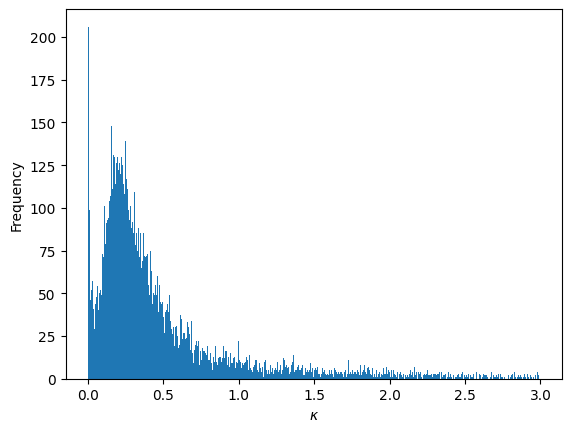

In [14]:
d['k_obs'].plot.hist(bins=1000)
#plt.xlim([0,.5])
plt.xlabel(r'$\kappa$')
plt.savefig('../figures/k_obs_hist.png', dpi=300)

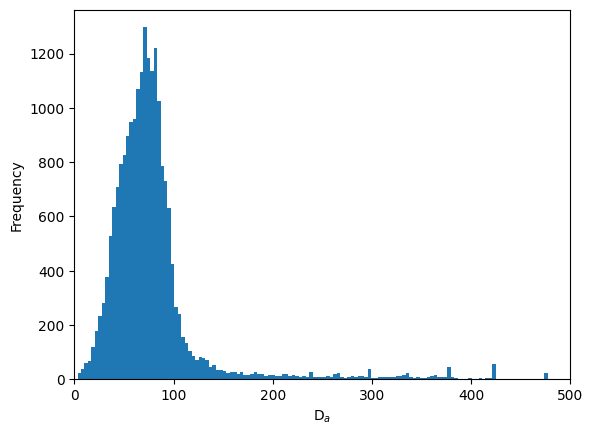

In [15]:
d['D_a'].plot.hist(bins=1000)
plt.xlabel('D$_a$')
plt.xlim([0,500])
plt.savefig('../figures/D_a_hist.png', dpi=300)

Text(0.5, 0, 'Measured CCN [cm$^{-3}$]')

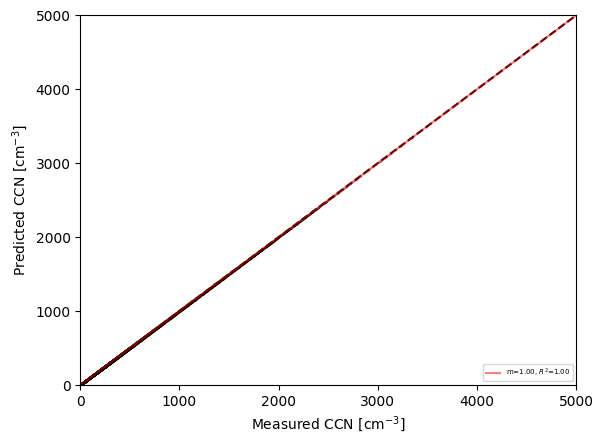

In [16]:
merged = sub_m2_og
plt.scatter(merged['N_CCN_stdPT'], merged['CCN_n_pred'], s=.1, c='black', alpha=.3)
plt.plot([0,5000], [0,5000], c='black', ls='--')
plt.xlim([0,5000])
plt.ylim([0,5000])
md = merged[['N_CCN_stdPT', 'CCN_n_pred']].dropna()
slope, intercept, r_value, p_value, std_err = linregress(md['N_CCN_stdPT'], md['CCN_n_pred'])
# Calculate the line of best fit
fit_line = slope * np.linspace(0, 5000) + intercept
plt.plot(np.linspace(0, 5000), fit_line, c='r', label=f'm={slope:.2f}, $R^2$={r_value**2:.2f}', alpha=.5)
plt.legend(fontsize=5, loc='lower right')


plt.ylabel('Predicted CCN [cm$^{-3}$]')
plt.xlabel('Measured CCN [cm$^{-3}$]')

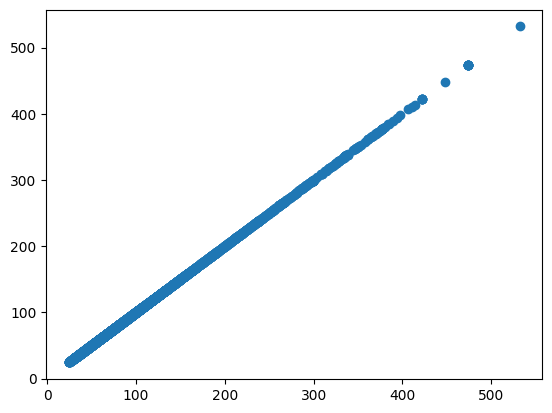

In [17]:
plt.scatter(merged['D_a'], merged['D_c'])

/var/folders/tf/wjndf74j55q6hwwhxhpzl0100000gn/T/ipykernel_33319/3935471433.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(Ks, labels=s_labels,showfliers=False)


Text(0.5, 0, 's [%]')

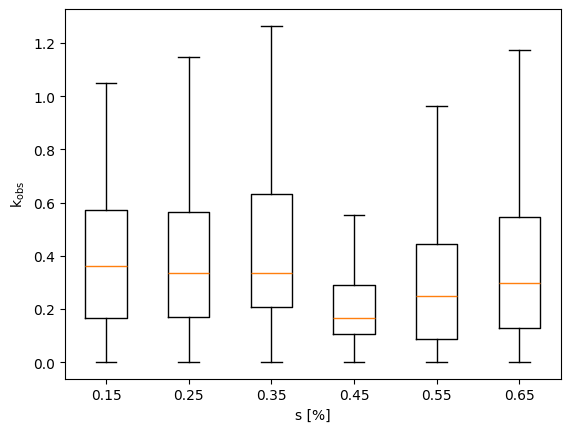

In [18]:
min_s = np.arange(.1,.7,.1)
max_s = np.arange(.2,.8,.1)
s_labels = np.arange(.15,.75,.1).round(2)
#s_labels = (min_o + max_o) / 2

Ks = []
for i in range(0,len(min_s)):
    Ks.append(d['k_obs'][(d['CCN_SS'] < max_s[i]) & (d['CCN_SS'] >= min_s[i])].dropna())

plt.boxplot(Ks, labels=s_labels,showfliers=False)
plt.ylabel(r'k$_{\rm obs}$')
plt.xlabel('s [%]')

/var/folders/tf/wjndf74j55q6hwwhxhpzl0100000gn/T/ipykernel_33319/2151388363.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(Ks, labels=s_labels,showfliers=False)


Text(0.5, 0, 's [%]')

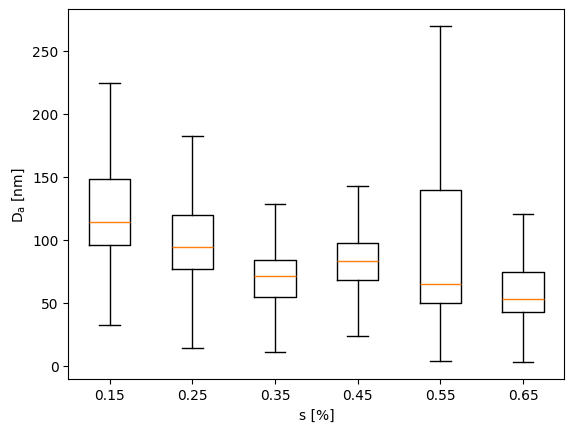

In [19]:
fig, ax = plt.subplots()
d_p = d#d[(d['k_obs']>min_k[i]) & (d['k_obs']<min_k[i]+.5)]
min_s = np.arange(.1,.7,.1)
max_s = np.arange(.2,.8,.1)
s_labels = np.arange(.15,.75,.1).round(2)
#s_labels = (min_o + max_o) / 2

Ks = []
for i in range(0,len(min_s)):
    Ks.append(d_p['D_a'][(d['CCN_SS'] < max_s[i]) & (d_p['CCN_SS'] >= min_s[i])].dropna())

ax.boxplot(Ks, labels=s_labels,showfliers=False)
plt.ylabel(r'D$_{\rm a}$ [nm]')
plt.xlabel('s [%]')

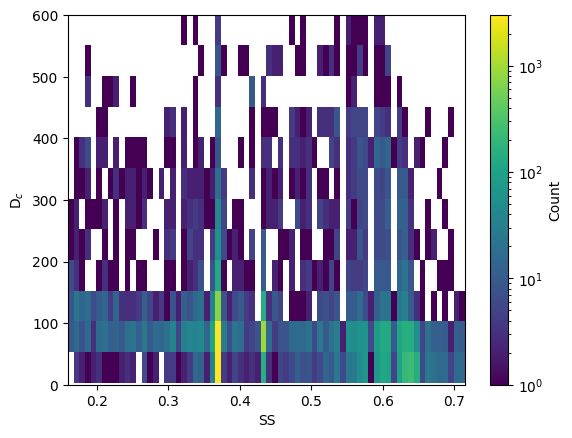

In [20]:
log_norm = mcolors.LogNorm(vmin=1, vmax=3000)
d_act = d[np.isfinite(d['CCN_SS']) & (np.isfinite(d['D_a']))]
plt.hist2d(d_act['CCN_SS'], d_act['D_a'], bins=70, cmap='viridis', norm=log_norm)
plt.colorbar(label='Count', norm=log_norm)
plt.ylim([0,600])
plt.xlabel('SS')
plt.ylabel('D$_c$')
plt.savefig('../figures/D_c-SS_obs_obs.png', dpi=300)

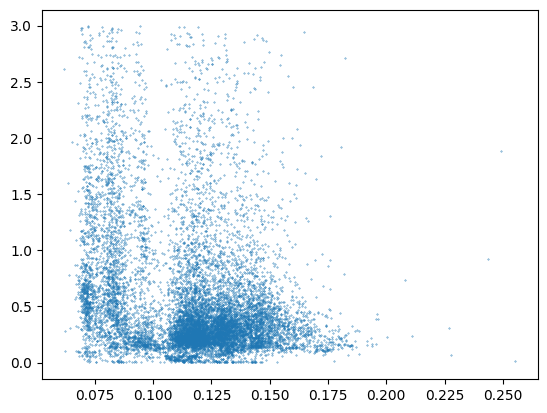

/var/folders/tf/wjndf74j55q6hwwhxhpzl0100000gn/T/ipykernel_33319/1138843076.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d_sub['CO_range'] = pd.cut(d_sub['CO_ppm'], bins=bins, labels=labels, right=False)


<Figure size 1000x600 with 0 Axes>

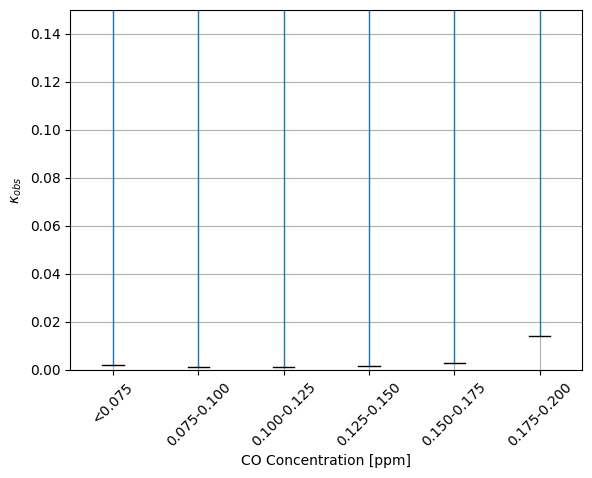

<Figure size 1000x600 with 0 Axes>

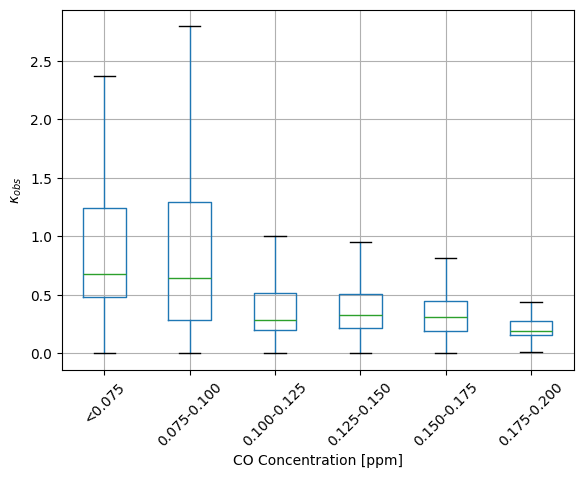

In [21]:
d_sub = d[d['CCN_SS']==0.37]
plt.scatter(d_sub['CO_ppm'], d_sub['k_obs'], s=.1)
#plt.ylim([0,.1])

# Assuming 'd' is your DataFrame containing 'CO_ppm' and 'k_obs' columns
# Define CO_ppm ranges (bins) - adjust as needed
bins = [0, 0.075, 0.100, 0.125, 0.150, 0.175, 0.200]
labels = ['<0.075', '0.075-0.100', '0.100-0.125', '0.125-0.150', '0.150-0.175', '0.175-0.200']
plt.show()
# Bin 'CO_ppm' values
d_sub['CO_range'] = pd.cut(d_sub['CO_ppm'], bins=bins, labels=labels, right=False)

# Plot boxplot of 'k_obs' for each CO_ppm range
plt.figure(figsize=(10, 6))
d_sub.boxplot(column='k_obs', by='CO_range', grid=True, showfliers=False)
plt.title('')
plt.suptitle('')  # Removes the automatic boxplot subtitle
plt.xlabel('CO Concentration [ppm]')
plt.ylabel(r'$\kappa _{obs}$')
plt.xticks(rotation=45)
plt.ylim([0, 0.15])
plt.savefig('../figures/COvk_obs_zoomed.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(10, 6))
d_sub.boxplot(column='k_obs', by='CO_range', grid=True, showfliers=False)
plt.title('')
plt.suptitle('')  # Removes the automatic boxplot subtitle
plt.xlabel('CO Concentration [ppm]')
plt.ylabel(r'$\kappa _{obs}$')
plt.xticks(rotation=45)
#plt.ylim([0, 0.15])
plt.savefig('../figures/COvk_obs.png', dpi=300, bbox_inches='tight')
plt.show()